# Collection of different norms in reproducing kernel Hilbert spaces (RKHS)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import math
from scipy.stats import gamma
import random

Different combinations of $(X, Y)$ to evaluate the approximation methods

In [14]:
#X = np.random.normal(2, 1, 64).reshape(-1,1)
#X = np.random.exponential(size=100).reshape(-1,1)
#X = np.random.chisquare(1, size=20).reshape(-1,1)
#X = np.random.multivariate_normal([0,1,2], [[1,1,1], [1,1,1], [1,1,1]], size=128)
X = np.random.randn(20*128).reshape(20,-1)


#Y = np.random.exponential(size=64).reshape(-1,1)
Y = np.random.randn(20*128).reshape(20,-1)
#Y = X**3 #+ np.random.multivariate_normal([10,11,12], [[10,10,10], [10,10,10], [10,10,10]], size=128)

In [ ]:
plt.hist(X, bins=1000);

In [ ]:
plt.hist(Y, bins=1000);

Show quickly some distribution characteristics:

In [15]:
print('X:')
print(X.mean())
print(X.std())
print('-----------------------')
print('Y:')
print(Y.mean())
print(Y.std())

X:
-0.013425514430122016
1.0142875773383466
-----------------------
Y:
-0.0034173089032113802
0.9970025596721123


Show their dependence:

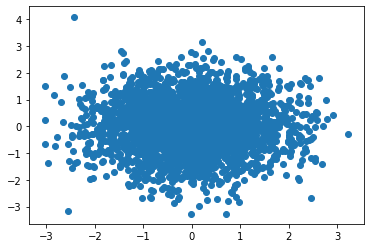

In [16]:
plt.scatter(X, Y);

### Auxiliary functions

In [39]:
# median heuristic for kernel width
def width(Z):
    # compute median for Z
    size_Z = Z.shape[0]
    if size_Z > 100:
        Z_med = Z[0:100]
        size_Z = 100
    else:
        Z_med = Z

    G_Z = np.sum(np.multiply(Z_med, Z_med), axis=1).reshape(-1,1)
    Q_Z = np.tile(G_Z, (1, size_Z))
    R_Z = np.tile(G_Z.T, (size_Z, 1))
    dists_Z = Q_Z + R_Z - 2 * Z_med @ Z_med.T
    distances_Z = (dists_Z - np.tril(dists_Z)).reshape(-1, 1)
    width_Z = np.sqrt(0.5*np.median(distances_Z[distances_Z>0]))
    d_Z = Z.shape[1]
    
    return d_Z * width_Z


# rbf dot product
def rbf_dot(X, Y, width):
    size_X = X.shape
    size_Y = Y.shape
    
    G = np.sum(np.multiply(X, X), axis=1).reshape(-1,1)
    H = np.sum(np.multiply(Y, Y), axis=1).reshape(-1,1)
    
    Q = np.tile(G, (1, size_Y[0]))
    R = np.tile(H.T, (size_X[0], 1))
    
    H = Q + R - 2 * X @ Y.T
    
    # rbf kernel
    K = np.exp(-H/(2*width**2))
    
    return K

# Biased MMD

First, we compute the biased MMD to have a measure how different the two distributions $P_X$ and $P_Y$ are in the RKHS.

In [40]:
# biased MMD estimator
def MMD_b(X, Y, width_X, width_Y):
    
    m = X.shape[0]
    
    # median heuristics for kernel width
    if width_X == -1:
        width_X = width(X)      
    if width_Y == -1:
        width_Y = width(Y)
    
    K = rbf_dot(X, X, width_X)
    L = rbf_dot(Y, Y, width_Y)
    
    # centering matrix
    H = np.eye(m) - (1/m) * (np.ones((m, m)))
    
    return (1/m**2) * np.trace(K @ H @ L @ H)

In [41]:
MMD_b(X, Y, width_X=-1, width_Y=-1)

1.775419288158862e-10

# Unbiased MMD
Next, we compute the MMD with bias correction.

In [42]:
# unbiased MMD estimator
def MMD_u(X, Y, width_X, width_Y, width_XY):
    m = X.shape[0]
    
    # median heuristics for kernel width
    if width_X == -1:
        width_X = width(X)      
    if width_Y == -1:
        width_Y = width(Y)
    if width_XY == -1:
        width_XY = width(np.concatenate([X, Y]))
    
    K = rbf_dot(X, X, width_X)
    L = rbf_dot(Y, Y, width_Y)
    KL = rbf_dot(X, Y, width_XY)
    
    # centering matrix
    H = np.eye(m) - (1/m) * (np.ones((m, m)))
    
    return np.sqrt(1/(m*(m-1)) * (np.sum(K) + np.sum(L) - 2 * np.sum(KL)))

In [43]:
MMD_u(X, Y, -1, -1, -1)

0.0025646379550416055

# HSIC

$\mathcal{H}_0 : P_{XY} = P_X P_Y$ is a complex distribution and must be approximated. Here, we approximate it first by randomly permuting the order of $Y$ whilst the order of $X$ is kept fixed, and second by a Gamma distribution with parameters $\alpha$ (`al`) and $\beta$ (`bet`).

## HSIC with permutations

In [44]:
def HSIC_permutations(X, Y, alpha, width_X, width_Y, shuffle):    # set widths to -1 for median heuristics
    
    m = X.shape[0]
    
    # median heuristics for kernel width
    if width_X == -1:
        width_X = width(X)      
    if width_Y == -1:
        width_Y = width(Y)
    
    # compute Gram matrices
    K = rbf_dot(X, X, width_X)
    L = rbf_dot(Y, Y, width_Y)
    
    # centering matrix...
    H = np.eye(m) - (1/m) * (np.ones((m, m)))
    
    # ...to center K
    K_c = H @ K @ H
    
    # test statistic
    stat = 1/(m**2) * np.sum(np.multiply(K_c.T, L))
    
    # initiating HSIC
    HSIC_arr = np.zeros(shuffle)
    
    # create permutations by reshuffling L except the main diagonal
    for sh in range(shuffle):
        n = ~np.eye(len(L), dtype=bool)
        Ln = L[n]
        np.random.shuffle(Ln)
        L[n] = Ln
        HSIC_arr[sh] = 1/(m**2) * np.sum(np.multiply(K_c.T, L))
        
    HSIC_arr_sort = np.sort(HSIC_arr)
    
    # computing 1-alpha threshold
    threshold = HSIC_arr_sort[round((1-alpha)*shuffle)]
    
    if stat > threshold:
        print('H0 rejected')
    else:
        print('H0 accepted')
    
    return (stat, threshold)

## HSIC with Gamma distribution approximation

In [45]:
def HSIC_gamma(X, Y, alpha, width_X, width_Y):    # set widths to -1 for median heuristics
    
    m = X.shape[0]
    
    # median heuristics for kernel width
    if width_X == -1:
        width_X = width(X)      
    if width_Y == -1:
        width_Y = width(Y)
    
    # compute Gram matrices
    K = rbf_dot(X, X, width_X)
    L = rbf_dot(Y, Y, width_Y)
    
    # centering matrix...
    H = np.eye(m) - (1/m) * (np.ones((m, m)))
    
    # ...to center K and L
    K_c = H @ K @ H
    L_c = H @ L @ H
    
    # test statistic
    stat = 1/m * np.sum(np.multiply(K_c.T, L))
    
    # fitting Gamma distribution to stat*m
    vHSIC = np.power(1/6 * np.multiply(K_c, L_c), 2)
    vaHSIC = 1/(m*(m-1)) * (np.sum(vHSIC) - np.trace(vHSIC))
    varHSIC = 72*(m-4)*(m-5)/(m*(m-1)*(m-2)*(m-3)) * vaHSIC    # variance under H0
        
    K_diag = K - np.diag(np.diag(K))
    L_diag = L - np.diag(np.diag(L))
    
    bone = np.ones(m)
    
    mu_X = 1/(m*(m-1)) * bone @ (K @ bone)
    mu_Y = 1/(m*(m-1)) * bone @ (L @ bone)
    
    mHSIC = 1/m * (1 + mu_X * mu_Y - mu_X - mu_Y)    # mean under H0
    
    al = mHSIC**2 / varHSIC
    bet = varHSIC * m / mHSIC
    
    # computing 1-alpha threshold
    threshold = gamma.ppf(1-alpha, al, scale=bet)
    
    if stat > threshold:
        print('H0 rejected')
    else:
        print('H0 accepted')
    
    return (stat, threshold)

### Evaluations

In [46]:
# test level alpha = 0.05
HSIC_permutations(X, Y, 0.05, -1, -1, 5000)

H0 accepted


(1.775419288157741e-10, 1.828803704932952e-10)

In [47]:
# test level alpha = 0.05
HSIC_gamma(X, Y, 0.05, -1, -1)

H0 accepted


(3.550838576315482e-09, 0.0027636120458583925)